# Differential Expression with limma-voom pipeline - Transcripts

In [1]:
suppressMessages(library(SummarizedExperiment))
suppressMessages(library(data.table))
suppressMessages(library(calibrate))
suppressMessages(library(ggplot2))
suppressMessages(library(limma))
suppressMessages(library(edgeR))
suppressMessages(library(sva))

## Prepare Data

In [2]:
# Function from jaffelab github
merge_rse_metrics <- function(rse) {
    stopifnot(is(rse, 'RangedSummarizedExperiment'))
    stopifnot(
        c('concordMapRate', 'overallMapRate', 'mitoRate', 'rRNA_rate',
          'totalAssignedGene', 'numMapped', 'numReads', 'numUnmapped',
          'mitoMapped', 'totalMapped') %in%
            colnames(SummarizedExperiment::colData(rse))
    )

    stopifnot(all(sapply(c(
        'concordMapRate', 'overallMapRate', 'mitoRate', 'rRNA_rate',
        'totalAssignedGene', 'numMapped', 'numReads', 'numUnmapped',
        'mitoMapped', 'totalMapped'), function(var) {
            is(colData(rse)[, var], 'List')
        })
    ))

    rse$concordMapRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$concordMapRate, rse$numReads)
    rse$overallMapRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$overallMapRate, rse$numReads)
    rse$mitoRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$mitoRate, rse$numMapped)
    rse$rRNA_rate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$rRNA_rate, rse$numMapped)
    rse$totalAssignedGene = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$totalAssignedGene, rse$numMapped)

    rse$numMapped = sapply(rse$numMapped, sum)
    rse$numReads = sapply(rse$numReads, sum)
    rse$numUnmapped = sapply(rse$numUnmapped, sum)
    rse$mitoMapped = sapply(rse$mitoMapped, sum)
    rse$totalMapped = sapply(rse$totalMapped, sum)
    return(rse)
}

### Load counts

In [3]:
counts.files = '/ceph/projects/v3_phase3_paper/inputs/phase3/transcripts_counts/_m/counts.txt'
df.raw0 <- fread(counts.files, header=TRUE, data.table = FALSE)

In [4]:
rownames(df.raw0) = df.raw0[, 1]
annot <- df.raw0[, 1:5]
df.raw <- df.raw0[, c(-1:-5)]

print(dim(df.raw))
print(dim(annot))

[1] 198093    487
[1] 198093      5


In [5]:
counts = as.matrix(df.raw)
head(counts)

,R12864,R12865,R12866,R12867,R12868,R12869,R12870,R12871,R12872,R12873,⋯,R13494,R13495,R13496,R13497,R13498,R13499,R13500,R13502,R13503,R13504
ENST00000456328.2,29.2079,23.44200,27.571,15.9645,3.48495,40.43680,28.661100,24.6035,9.64358,10.5632,⋯,22.3987,21.8496,8.4245,12.9042,9.03499,16.8525,10.9128,1.7512,20.8775,38.5875
ENST00000450305.2,0.0000,0.00000,0.000,0.0000,0.00000,0.00000,0.123021,0.0000,0.00000,0.0000,⋯,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000
ENST00000488147.1,138.2910,130.95800,169.706,118.7210,111.02800,187.58000,196.186000,145.3650,150.10400,132.8560,⋯,268.2340,177.0720,159.0050,105.0330,123.68400,213.9630,240.9180,92.6490,122.4970,242.5640
ENST00000619216.1,0.0000,0.50000,0.250,0.0000,0.00000,0.00000,0.000000,0.0000,0.00000,0.0000,⋯,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000
ENST00000473358.1,0.0000,0.00000,0.000,0.0000,0.00000,2.44754,0.000000,0.0000,0.00000,0.0000,⋯,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000
ENST00000469289.1,0.0000,1.24047,0.000,0.0000,0.00000,1.19137,0.000000,0.0000,0.00000,0.0000,⋯,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000


### Load R variable

In [6]:
load("/ceph/projects/v3_phase3_paper/inputs/phase3/_m/count_data/caudate_brainseq_phase3_hg38_rseTx_merged_n464.rda")
rse_tx

class: RangedSummarizedExperiment 
dim: 198093 464 
metadata(0):
assays(1): tpm
rownames(198093): ENST00000456328.2 ENST00000450305.2 ...
  ENST00000387460.2 ENST00000387461.2
rowData names(22): source type ... protein_id ccdsid
colnames(464): R12864 R12865 ... R13503 R13504
colData names(71): BrNum RNum ... RNum.1 FlowCell

In [7]:
all(rownames(assays(rse_tx)$tpm) == rownames(counts))

[1] TRUE

In [8]:
if(!all(colnames(assays(rse_tx)$tpm) == colnames(counts)))
{
    assays(rse_tx)$counts = counts[, colnames(rse_tx)]
}

Warning message in colnames(assays(rse_tx)$tpm) == colnames(counts):
"longer object length is not a multiple of shorter object length"

### Load genotype data

In [9]:
load("/ceph/projects/v3_phase3_paper/inputs/phase3/_m/genotype_data/BrainSeq_Phase3_Caudate_RiboZero_MDSonly_n464.rda")
colData(rse_tx) = cbind(colData(rse_tx), mds)
rse_tx

class: RangedSummarizedExperiment 
dim: 198093 464 
metadata(0):
assays(2): tpm counts
rownames(198093): ENST00000456328.2 ENST00000450305.2 ...
  ENST00000387460.2 ENST00000387461.2
rowData names(22): source type ... protein_id ccdsid
colnames(464): R12864 R12865 ... R13503 R13504
colData names(81): BrNum RNum ... snpPC9 snpPC10

### Subset and recode

In [10]:
keepIndex = which((rse_tx$Dx == 'Control' | rse_tx$Dx == 'Schizo') & rse_tx$Age > 17)
rse_tx = rse_tx[, keepIndex]
rse_tx

class: RangedSummarizedExperiment 
dim: 198093 394 
metadata(0):
assays(2): tpm counts
rownames(198093): ENST00000456328.2 ENST00000450305.2 ...
  ENST00000387460.2 ENST00000387461.2
rowData names(22): source type ... protein_id ccdsid
colnames(394): R12864 R12865 ... R13503 R13504
colData names(81): BrNum RNum ... snpPC9 snpPC10

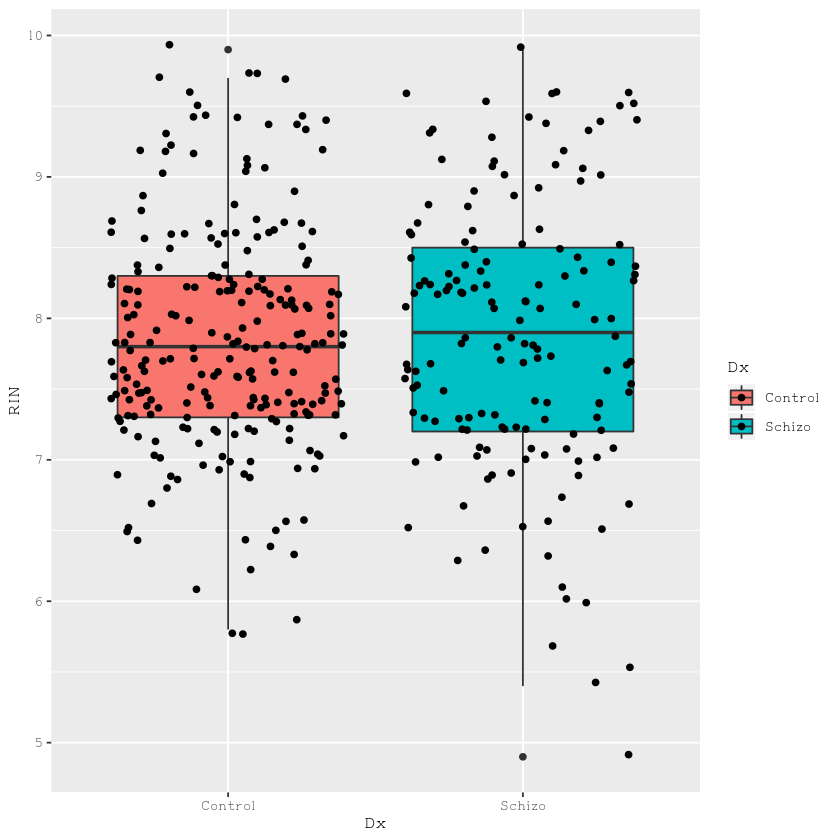

In [11]:
rse_tx$Dx = factor(rse_tx$Dx, levels = c("Control", "Schizo"))
rse_tx$Sex <- factor(rse_tx$Sex)

rse_tx <- merge_rse_metrics(rse_tx)

rse_tx$ERCCsumLogErr <- mapply(function(r, n) {
        sum(r * n)/sum(n)
    }, rse_tx$ERCCsumLogErr, rse_tx$numReads)
colData(rse_tx)$RIN = sapply(colData(rse_tx)$RIN,"[",1)

ggplot(data.frame(colData(rse_tx)), aes(x=Dx, y=RIN, fill=Dx)) + geom_boxplot() + geom_jitter()

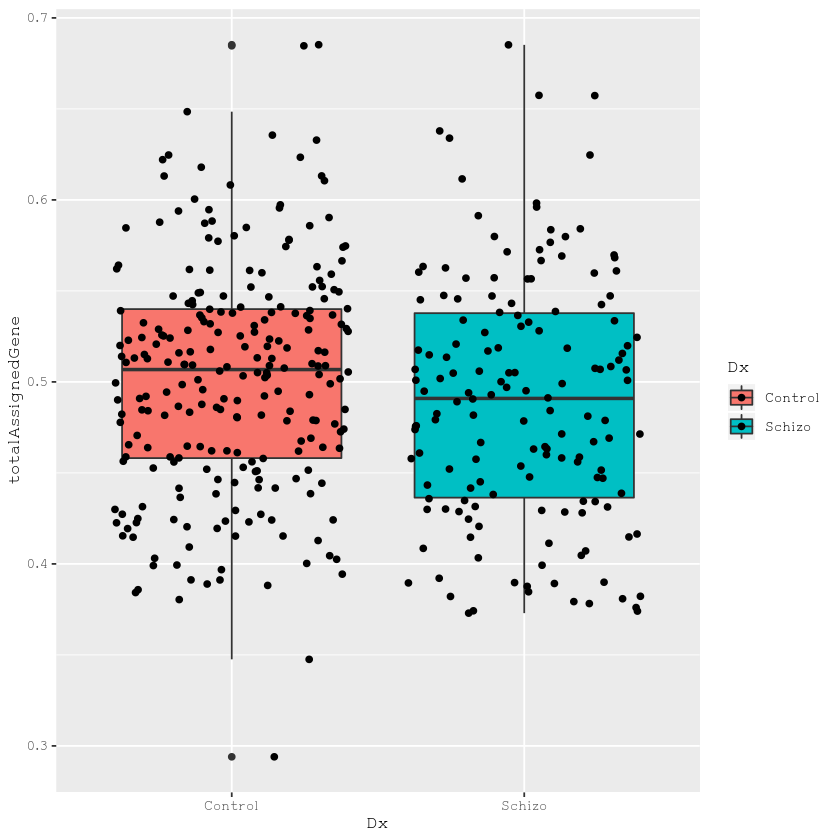

In [12]:
ggplot(data.frame(colData(rse_tx)), aes(x=Dx, y=totalAssignedGene, fill=Dx)) + geom_boxplot() + geom_jitter()

### Generate DGEList

In [13]:
x <- DGEList(counts=assays(rse_tx)$counts, 
             genes=rowData(rse_tx), 
             samples=colData(rse_tx))

### Filtering low counts

In [14]:
design0 <- model.matrix(~Dx, data=x$samples)
keep.x <- filterByExpr(x, design=design0)
x <- x[keep.x, , keep.lib.sizes=FALSE]
print(paste('There are:', sum(keep.x), 'features left!', sep=' '))

[1] "There are: 102241 features left!"


### Normalize counts

In [15]:
x <- calcNormFactors(x, method="TMM")

## Differential Expression Analysis

### Design matrix

In [16]:
mod = model.matrix(~Dx + Age + Sex + mitoRate + rRNA_rate + totalAssignedGene + 
                   RIN + ERCCsumLogErr + overallMapRate + snpPC1 + snpPC2 + 
                   snpPC3 + snpPC4 + snpPC5, data = colData(rse_tx))

colnames(mod) <- gsub("Dx", "", colnames(mod))
colnames(mod) <- gsub("SexM", "Male", colnames(mod))
colnames(mod) <- gsub("\\(Intercept\\)", "Intercept",
                         colnames(mod))

head(mod, 2)

,Intercept,Schizo,Age,Male,mitoRate,rRNA_rate,totalAssignedGene,RIN,ERCCsumLogErr,overallMapRate,snpPC1,snpPC2,snpPC3,snpPC4,snpPC5
R12864,1,1,42.98,0,0.03265387,8.675159e-05,0.5148545,9.6,-59.97567,0.9093498,0.0493213,-0.00560004,-1.25945e-03,0.00109117,0.000905945
R12865,1,1,53.12,1,0.01978740,6.976684e-05,0.5207789,9.5,-45.71034,0.8734840,0.0630991,-0.00499613,2.93356e-05,0.00104552,-0.001195790


### Load degradation matrix

In [17]:
load("/ceph/projects/v3_phase3_paper/inputs/phase3/_m/count_data/degradation_rse_phase3_caudate.rda")
cov_rse_caudate = cov_rse_caudate[, keepIndex]

### Calculate qSVAs

In [18]:
dm <- assays(cov_rse_caudate)$counts
qSV <- qsva(dm)

if("TRUE" %in% grepl("_", rownames(qSV))){# Remove underscore if needed                       
    rownames(qSV) <- sapply(strsplit(rownames(qSV), "_"), "[", 1)
}

### Merge models

In [19]:
modQsva <- merge(mod, qSV, by=0, all=FALSE)
rownames(modQsva) <- modQsva$Row.names
modQsva  <- modQsva[,-1]

dim(modQsva)[1] == dim(x$counts)[2]

[1] TRUE

### Preform voom

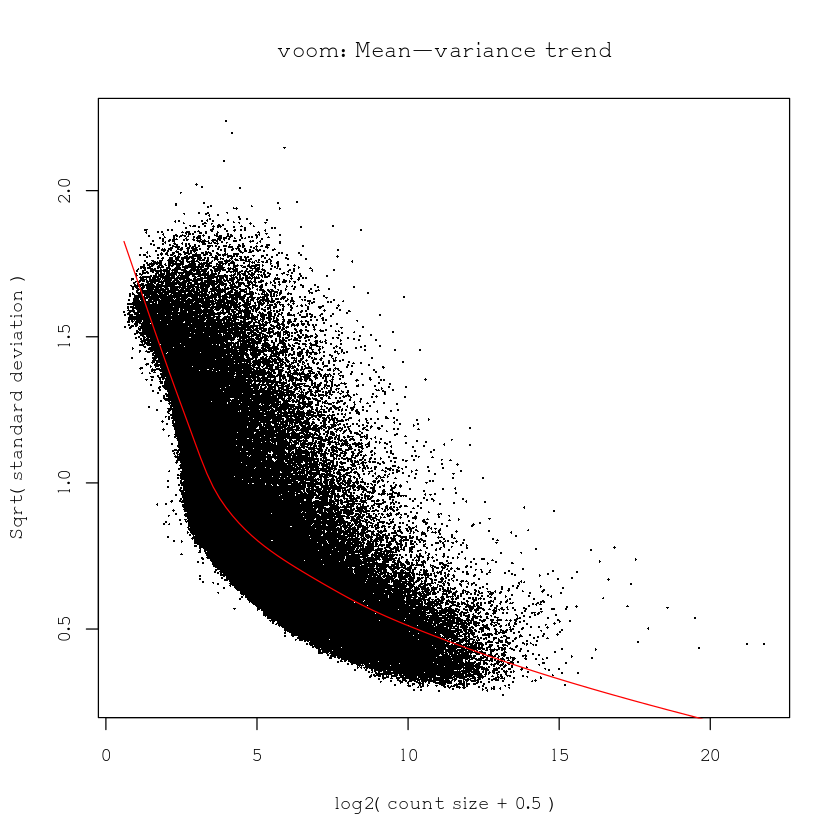

In [20]:
v <- voom(x, modQsva, plot=TRUE)

In [21]:
v$E[1:5, 1:5]

,R12864,R12865,R12866,R12867,R12868
ENST00000456328.2,-0.5456175,-0.73784406,-0.6871368,-1.4152276,-2.6324476
ENST00000488147.1,1.6783780,1.71914230,1.9129927,1.4409801,2.1742530
ENST00000461467.1,0.3706697,-0.09552261,0.5817085,0.9066303,0.8460601
ENST00000466430.5,1.4063951,0.27906129,1.9086379,2.6025488,1.0915059
ENST00000495576.1,-6.4383922,-6.31931583,-2.4706480,-6.4565144,-2.3091755


In [22]:
feature = 'transcripts'
dir.create(feature)

In [23]:
save(v, file=paste0(feature,'/voomSVA.RData'))

### Calculate residuals

In [24]:
null_model = v$design[, !(names(v$design) %in% c("Schizo"))]
fit_res <- lmFit(v, design=null_model)
res = v$E - ( fit_res$coefficients %*% t(null_model) )
res_sd = apply(res, 1, sd)
res_mean = apply(res, 1, mean)

### Normalize residuals and write to file

In [25]:
res_norm = (res - res_mean) / res_sd
write.table(res_norm, file=paste0(feature, '/residualized_expression.tsv'), sep="\t", quote=FALSE)

### Fit model with limma

In [26]:
fit0 <- lmFit(v, modQsva)
contr.matrix <- makeContrasts(CtrlvsSZ = Schizo, 
                              levels=colnames(modQsva))
fit <- contrasts.fit(fit0, contrasts=contr.matrix)

### Calculate differential expression with eBayes

In [27]:
esv <- eBayes(fit)

options(width=200)
top0 <- topTable(esv, coef=1, number=Inf, sort.by="P")
sigTest <- decideTests(esv)

top <- merge(top0, sigTest, by=0)
rownames(top) <- top$Row.names
top <- top[,-1]
top <- top[order(top$P.Value), ]
dim(top)

[1] 102241     29

In [28]:
head(top, 2)

,source,type,score,phase,gene_id,gene_type,gene_status,gene_name,level,havana_gene,⋯,ont,protein_id,ccdsid,logFC,AveExpr,t,P.Value,adj.P.Val,B,CtrlvsSZ
,<fct>,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENST00000381176.4,HAVANA,transcript,NA,NA,ENSG00000138944.7,protein_coding,KNOWN,KIAA1644,1,OTTHUMG00000030991.2,⋯,NA,ENSP00000370568.4,CCDS43025.1,0.5313968,4.6419714,11.90173,7.098561e-28,7.257640e-23,52.40953,1
ENST00000637926.1,HAVANA,transcript,NA,NA,ENSG00000248587.7,antisense,KNOWN,GDNF-AS1,2,OTTHUMG00000162110.3,⋯,NA,NA,NA,0.9182547,-0.6467146,11.43134,4.035539e-26,2.062988e-21,44.59707,1


In [29]:
write.table(top, file=paste0("../_m/", feature, "/diffExpr_szVctl_full.txt"), 
            sep='\t', row.names=TRUE, quote=FALSE)

### Subset via FDR

In [30]:
top.fdr <- top[top$adj.P.Val<=0.05,]
print(paste('There are:', dim(top.fdr)[1], 'DE features!'))

[1] "There are: 1908 DE features!"


In [31]:
write.table(top.fdr, file=paste0("../_m/", feature, "/diffExpr_szVctl_FDR05.txt"),
            sep='\t', row.names=TRUE, quote=FALSE)

## Volcano and MA plots

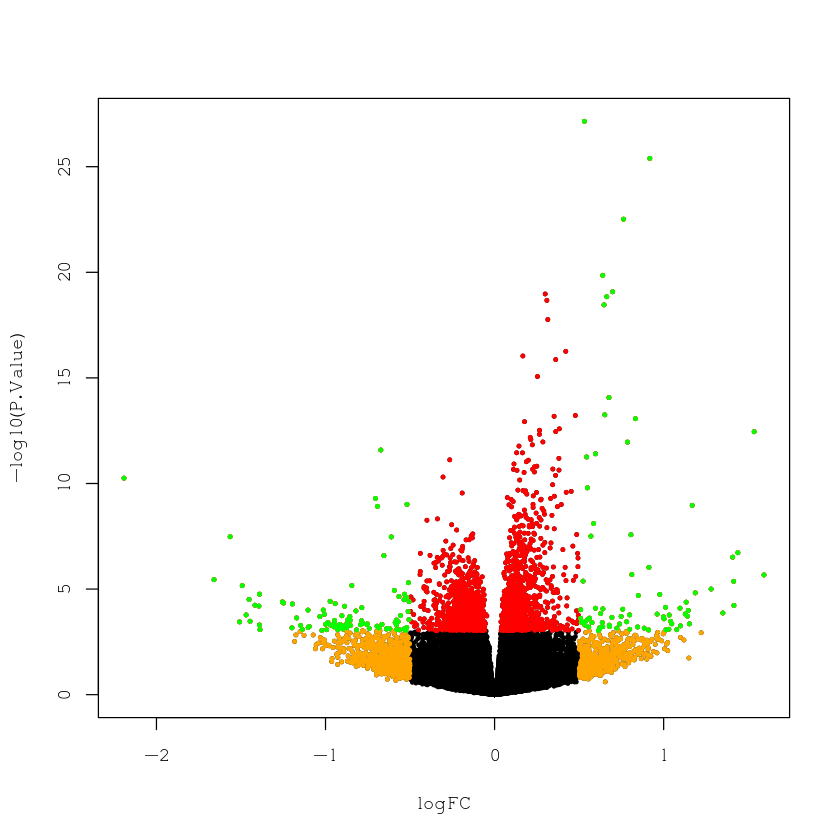

In [32]:
with(top, plot(logFC, -log10(P.Value), pch=20, cex=0.6))
with(subset(top, adj.P.Val<=0.05), points(logFC, -log10(P.Value),
                                          pch=20, col='red', cex=0.6))
with(subset(top, abs(logFC)>0.50), points(logFC, -log10(P.Value),
                                          pch=20, col='orange', cex=0.6))
with(subset(top, adj.P.Val<=0.05 & abs(logFC)>0.50),
     points(logFC, -log10(P.Value), pch=20, col='green', cex=0.6))

In [ ]:
pdf(file=paste0(feature, "/volcanoPlot.pdf"), 8, 6)
with(top, plot(logFC, -log10(P.Value), pch=20, cex=0.6))
with(subset(top, adj.P.Val<=0.05), points(logFC, -log10(P.Value),
                                          pch=20, col='red', cex=0.6))
with(subset(top, abs(logFC)>0.50), points(logFC, -log10(P.Value),
                                          pch=20, col='orange', cex=0.6))
with(subset(top, adj.P.Val<=0.05 & abs(logFC)>0.50),
     points(logFC, -log10(P.Value), pch=20, col='green', cex=0.6))
dev.off()

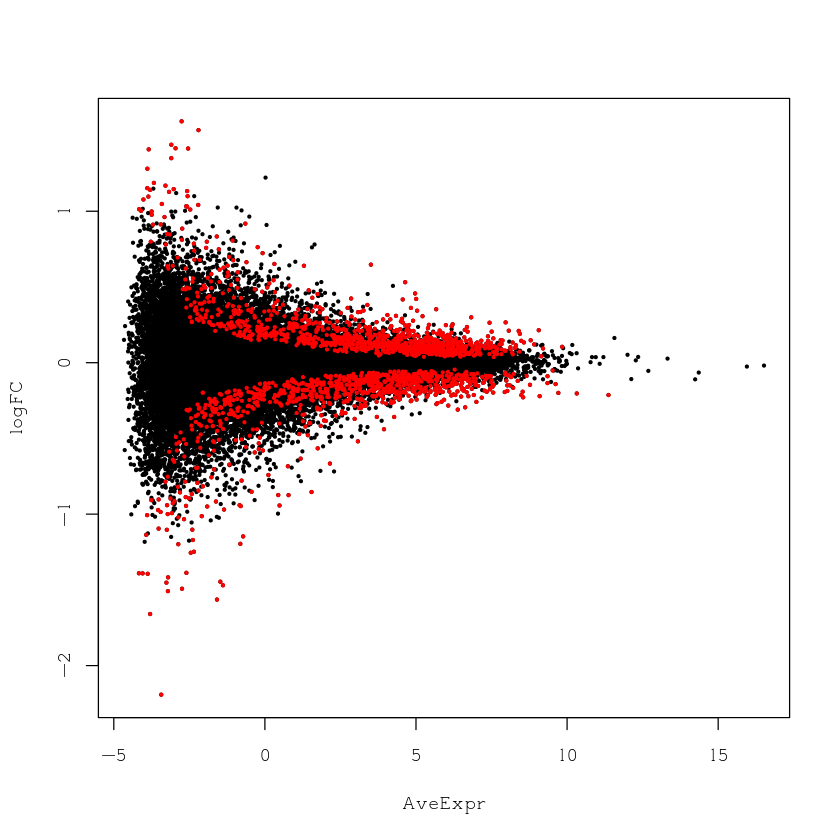

In [33]:
with(top, plot(AveExpr, logFC, pch=20, cex=0.5))
with(subset(top, adj.P.Val<0.05),
     points(AveExpr, logFC, col="red", pch=20, cex=0.5))

In [ ]:
pdf(file=paste0(feature, "/MAplot.pdf"), 8, 6)
with(top, plot(AveExpr, logFC, pch=20, cex=0.5))
with(subset(top, adj.P.Val<0.05),
     points(AveExpr, logFC, col="red", pch=20, cex=0.5))
dev.off()

## Repreducibility Information

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()